Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.8 MB/s eta 0:00:00


In [ ]:
# Log in to your W&B account
# 37c8a07c774e2e083984fb1eecd48091d723d40f
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [ ]:
import sys
import cv2 # Pour utiliser opencv-python, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

np.random.seed(0)

In [ ]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
DATA_FOLDER_PATH = '/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/'
JPEGIMAGES_FOLDER_PATH = '/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/JPEGImages/'

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [ ]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): #-> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()
print(num_images_per_label)
print(proportions_images_per_label)

{'elephant': 1038, 'lion': 1019, 'deer': 1344, 'cow': 1338, 'squirrel': 1200, 'german+shepherd': 1033, 'skunk': 188, 'horse': 1645, 'mole': 100, 'walrus': 215, 'weasel': 282, 'mouse': 185, 'buffalo': 904, 'grizzly+bear': 852, 'bat': 383, 'chimpanzee': 728, 'beaver': 193, 'rabbit': 1088, 'wolf': 589, 'bobcat': 630, 'seal': 988, 'collie': 1028, 'spider+monkey': 291, 'otter': 758, 'rat': 310, 'leopard': 720, 'zebra': 1170, 'sheep': 1420, 'blue+whale': 174, 'ox': 728, 'chihuahua': 567, 'hamster': 779, 'tiger': 877, 'giraffe': 1202, 'polar+bear': 868, 'dolphin': 946, 'fox': 664, 'siamese+cat': 500, 'persian+cat': 747, 'raccoon': 512, 'antelope': 1046, 'pig': 713, 'giant+panda': 874, 'killer+whale': 291, 'moose': 704, 'dalmatian': 549, 'humpback+whale': 709, 'gorilla': 872, 'rhinoceros': 696, 'hippopotamus': 684}
{'elephant': 0.0278, 'lion': 0.0273, 'deer': 0.036, 'cow': 0.0358, 'squirrel': 0.0321, 'german+shepherd': 0.0277, 'skunk': 0.005, 'horse': 0.0441, 'mole': 0.0027, 'walrus': 0.0058, 

In [ ]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Sucessfully created annotations.csv file.


In [ ]:
# labels_in_number = pd.read_csv(DATA_FOLDER_PATH+"classes.txt", delim_whitespace=True,header=None)
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        # print(line.split())
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [ ]:
from torchvision.io import read_image, ImageReadMode
from PIL import Image


class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(path = img_path, mode = ImageReadMode.RGB)
        # with open(img_path, 'rb') as f:
        #     image = Image.open(f)
        #     image = image.convert('RGB')  # convert to RGB


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class Subset_(AWA2Dataset) : 
    def __init__(self, dataset, indices, transform=None):
        super().__init__()
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index_in_AWA2Dataset = self.indices[index]
        image, label = self.dataset[original_index_in_AWA2Dataset]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

In [ ]:
# dataset = AWA2Dataset()
# image,label = dataset[4125]



# ## TODO : Change transforms. Currently this is not useful.
# dataset.transform = transforms.Compose([
#                         transforms.ToPILImage(),
#                         transforms.Resize((224, 224)),
#                         # transforms.RandomHorizontalFlip(),
#                         transforms.Grayscale(num_output_channels=3),
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.485, 0.456, 0.406), 
#                                              (0.229, 0.224, 0.225))])

# # Testing. All good
# random_index = np.random.randint(0, len(dataset))
# image, label = dataset[random_index]

In [ ]:
transforms_pipeline_train = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    
                    ## Data augmentation 
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(p=0.4),
                    # transforms.RandomApply(transforms.RandAugment(), p=0.4), # 40% of the time, apply a random additional combo of transformations #https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
                    transforms.ColorJitter(brightness=0.2,
                                            contrast=0.2,
                                            saturation=0.2,
                                            hue=0.1),
                    transforms.RandomCrop((224,224)),  # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 0.9), ratio=(0.5, 1.08,))
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_pipeline_test = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    transforms.CenterCrop((224,224)),   
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


In [ ]:
# Experiment with DataLoader. Everything works good
# dataloader = DataLoader(dataset = dataset, batch_size=4, shuffle=True)

# dataiter = iter(dataloader)
# data = next(dataiter)

# images, labels = data 


### ViT ###

In [ ]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.5 MB/s eta 0:00:00


### vit_pytorch ###

In [ ]:
import torch.nn as nn
# import timm
from vit_pytorch import ViT
from vit_pytorch import SimpleViT
# from vit_pytorch.efficient import ViT
# from linformer import Linformer

# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )
# vit_model =  ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=50,
#     transformer=efficient_transformer,
#     channels=3,
# )

vit_model = SimpleViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 50,
    dim = 1024,
    depth = 12,
    heads = 16,
    mlp_dim = 2048
)

vit_model.eval

<bound method Module.eval of SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1024, out_features=2048, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_featu

### ViT-ZSL ###

In [ ]:
# pip install timm

In [ ]:
# import timm
# import torch.nn as nn

# class ViT(nn.Module):
#     def __init__(self, model_name="vit_base_patch16_224_in21k", pretrained=True):
#         super(ViT, self).__init__()
#         self.vit = timm.create_model(model_name, pretrained=pretrained)
#         # Others variants of ViT can be used as well
#         '''
#         1 --- 'vit_small_patch16_224'
#         2 --- 'vit_base_patch16_224'
#         3 --- 'vit_large_patch16_224',
#         4 --- 'vit_large_patch32_224'
#         5 --- 'vit_deit_base_patch16_224'
#         6 --- 'deit_base_distilled_patch16_224',
#         '''

#         # Change the head depending of the dataset used 
#         self.vit.head = nn.Identity()
#     # def forward(self, x):
#     #     x = self.vit.patch_embed(x)
#     #     cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)  
#     #     if self.vit.dist_token is None:
#     #         x = torch.cat((cls_token, x), dim=1)
#     #     else:
#     #         x = torch.cat((cls_token, self.vit.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
#     #     x = self.vit.pos_drop(x + self.vit.pos_embed)
#     #     x = self.vit.blocks(x)
#     #     x = self.vit.norm(x)
        
#     #     return x[:, 0], x[:, 1:]
#     def forward(self, x):
#         # pass input x through ViT model
#         x = self.vit.patch_embed(x)
#         cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
#         if hasattr(self.vit, "dist_token") and self.vit.dist_token is not None:
#             x = torch.cat((cls_token, self.vit.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
#         else:
#             x = torch.cat((cls_token, x), dim=1)
#         x = self.vit.pos_drop(x + self.vit.pos_embed)
#         x = self.vit.blocks(x)
#         x = self.vit.norm(x)

#         # return the output
#         return x[:, 0]



# import collections
# from torch import optim
# use_cuda = torch.cuda.is_available()

# vit = ViT("vit_base_patch16_224_in21k")
# mlp_g = nn.Linear(1024, 85, bias=False)

# # vit_model = nn.ModuleDict({
# #     "vit": vit,
# #     "mlp_g": mlp_g})

# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         self.layers_dict = nn.ModuleDict({
#                "vit": vit,
#                "mlp_g": mlp_g
#               })
#     def forward(self,x):
#         layers = ["vit","mlp_g"]
#         for layer in layers:
#             x = self.layers_dict[layer](x)
#         return x

# vit_model = Net()

# # finetune all the parameters
# for param in vit_model.parameters():
#     param.requires_grad = True
    
# # move model to GPU if CUDA is available
# if use_cuda:
#     model = vit_model.cuda()

# optimizer = torch.optim.Adam([{"params": model.layers_dict.vit.parameters(), "lr": 0.00001, "weight_decay": 0.0001},
#                               {"params": model.layers_dict.mlp_g.parameters(), "lr": 0.001, "weight_decay": 0.00001}])
                              
# lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30, 40], gamma=0.5)
# #lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)


# # # train attributes
# # train_attrbs = attrs_mat[uniq_train_labels]
# # train_attrbs_tensor = torch.from_numpy(train_attrbs)
# # # trainval attributes
# # trainval_attrbs = attrs_mat[uniq_trainval_labels]
# # trainval_attrbs_tensor = torch.from_numpy(trainval_attrbs)
# # if use_cuda:
# #     train_attrbs_tensor = train_attrbs_tensor.cuda()
# #     trainval_attrbs_tensor = trainval_attrbs_tensor.cuda()

### CUDA ###

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4213882242217318790
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 39552876544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1112394141187011863
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [ ]:
vit_model.to(device)

SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1024, out_features=2048, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=2048, out_features=1024, 

### Question: check dimension de dataloader   ###

###  Split training data and test data ###

In [ ]:
# Initialize dataset and train/valid/test split 
from sklearn.model_selection import train_test_split

dataset = AWA2Dataset()
n_images = len(dataset)
# Split all indices into training/testing sets
train_indices, test_indices = train_test_split(range(n_images), test_size=0.2, random_state=1)
# Split training indices into training/validation sets.
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=1)


# Initialize the 3 DataSet objects (as Subset_) and apply the relevant Transforms to each subset (train/test/valid)
train_data = Subset_(dataset, train_indices, transform = transforms_pipeline_train)
valid_data = Subset_(dataset, valid_indices, transform = transforms_pipeline_test)
test_data  = Subset_(dataset, test_indices, transform = transforms_pipeline_test) 

# Initalize DataLoaders
batch_size = 128

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

In [ ]:
# batch_size = 128

In [ ]:
# dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
# train_size = int(0.7*len(dataset))
# valid_size = int(0.2*len(dataset))
# test_size = len(dataset) - train_size - valid_size

In [ ]:
# train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,valid_size,test_size])

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=2, pin_memory=True)
# valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=2, pin_memory=True)

###   transfomer labels  ###

In [ ]:
path_class = DATA_FOLDER_PATH +"classes.txt"
class_animal = pd.read_table(path_class,header= None)

In [ ]:
animals = class_animal[1]
dict_label_animal = {}
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels) 

###   Loss function  ###

In [ ]:
# lr = 1e-3

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()

# vit_pytorch
# optimizer = optim.SGD(vit_model.parameters(), lr= lr, momentum=0.9)
# optimizer = optim.Adam(vit_model.parameters(), lr=lr)

# ViT-ZSL
# optimizer = torch.optim.Adam([{"params": vit_model.layers_dict.vit.parameters(), "lr": 0.00001, "weight_decay": 0.0001},
#                               {"params": vit_model.layers_dict.mlp_g.parameters(), "lr": 0.001, "weight_decay": 0.00001}])

###  Training  ###

In [ ]:
# pip install --upgrade timm

In [ ]:
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm



# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=1e-5) ### Added weight decay 
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


wandb.init(
    # set the wandb project where this run will be logged
    project="SimpleViT-DA",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "SimpleViT",
    "dataset": "AWA2",
    "epochs": 50,
    }
)

for epoch in range(50):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = vit_model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step() ### SHOULD BE HERE 

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = vit_model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    # log metrics to wandb
    wandb.log({"loss" : epoch_loss , "acc": epoch_accuracy, "val_loss" : epoch_val_loss, "val_acc": epoch_val_accuracy})


# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.5024 - acc: 0.1030 - val_loss : 3.2014 - val_acc: 0.1584



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.0908 - acc: 0.1848 - val_loss : 2.8369 - val_acc: 0.2424



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.8310 - acc: 0.2451 - val_loss : 2.6953 - val_acc: 0.2717



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.6633 - acc: 0.2876 - val_loss : 2.5257 - val_acc: 0.3142



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.5344 - acc: 0.3164 - val_loss : 2.4279 - val_acc: 0.3263



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.4369 - acc: 0.3330 - val_loss : 2.3453 - val_acc: 0.3621



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.3364 - acc: 0.3617 - val_loss : 2.3082 - val_acc: 0.3643



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.2702 - acc: 0.3737 - val_loss : 2.2830 - val_acc: 0.3784



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 9 - loss : 2.1885 - acc: 0.3967 - val_loss : 2.1628 - val_acc: 0.4117



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 10 - loss : 2.1218 - acc: 0.4095 - val_loss : 2.1180 - val_acc: 0.4204



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 11 - loss : 2.0376 - acc: 0.4306 - val_loss : 2.0663 - val_acc: 0.4340



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.9746 - acc: 0.4463 - val_loss : 2.0039 - val_acc: 0.4519



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 13 - loss : 1.9014 - acc: 0.4640 - val_loss : 2.0124 - val_acc: 0.4494



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 14 - loss : 1.8394 - acc: 0.4781 - val_loss : 1.8811 - val_acc: 0.4816



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 15 - loss : 1.7841 - acc: 0.4894 - val_loss : 1.9128 - val_acc: 0.4757



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 16 - loss : 1.7325 - acc: 0.5027 - val_loss : 1.8653 - val_acc: 0.4837



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 17 - loss : 1.6722 - acc: 0.5198 - val_loss : 1.8150 - val_acc: 0.4939



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 18 - loss : 1.6143 - acc: 0.5349 - val_loss : 1.7771 - val_acc: 0.5045



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 19 - loss : 1.5665 - acc: 0.5462 - val_loss : 1.8023 - val_acc: 0.5030



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 20 - loss : 1.5032 - acc: 0.5648 - val_loss : 1.7507 - val_acc: 0.5197



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 21 - loss : 1.4619 - acc: 0.5730 - val_loss : 1.7338 - val_acc: 0.5203



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 22 - loss : 1.4038 - acc: 0.5905 - val_loss : 1.6964 - val_acc: 0.5330



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 23 - loss : 1.3667 - acc: 0.5958 - val_loss : 1.6586 - val_acc: 0.5437



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 24 - loss : 1.3148 - acc: 0.6098 - val_loss : 1.6529 - val_acc: 0.5465



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 25 - loss : 1.2613 - acc: 0.6243 - val_loss : 1.6414 - val_acc: 0.5480



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 26 - loss : 1.2132 - acc: 0.6349 - val_loss : 1.6842 - val_acc: 0.5471



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 27 - loss : 1.1912 - acc: 0.6433 - val_loss : 1.6671 - val_acc: 0.5465



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 28 - loss : 1.1210 - acc: 0.6580 - val_loss : 1.6307 - val_acc: 0.5584



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 29 - loss : 1.0784 - acc: 0.6720 - val_loss : 1.6816 - val_acc: 0.5490



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 30 - loss : 1.0266 - acc: 0.6873 - val_loss : 1.6752 - val_acc: 0.5501



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.9782 - acc: 0.6997 - val_loss : 1.7064 - val_acc: 0.5525



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.9353 - acc: 0.7120 - val_loss : 1.6196 - val_acc: 0.5746



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.8932 - acc: 0.7228 - val_loss : 1.6401 - val_acc: 0.5744



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.8440 - acc: 0.7358 - val_loss : 1.6463 - val_acc: 0.5696



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.8151 - acc: 0.7470 - val_loss : 1.6945 - val_acc: 0.5693



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.7654 - acc: 0.7601 - val_loss : 1.6780 - val_acc: 0.5732



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.7196 - acc: 0.7707 - val_loss : 1.7082 - val_acc: 0.5643



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6918 - acc: 0.7809 - val_loss : 1.7113 - val_acc: 0.5673



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6502 - acc: 0.7940 - val_loss : 1.7400 - val_acc: 0.5663



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6319 - acc: 0.7971 - val_loss : 1.7589 - val_acc: 0.5641



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5739 - acc: 0.8149 - val_loss : 1.7297 - val_acc: 0.5762



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5510 - acc: 0.8199 - val_loss : 1.7615 - val_acc: 0.5762



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5089 - acc: 0.8389 - val_loss : 1.8032 - val_acc: 0.5611



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.4747 - acc: 0.8481 - val_loss : 1.7872 - val_acc: 0.5711



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.4612 - acc: 0.8508 - val_loss : 1.8261 - val_acc: 0.5664



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.4400 - acc: 0.8579 - val_loss : 1.7926 - val_acc: 0.5815



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.4065 - acc: 0.8699 - val_loss : 1.8634 - val_acc: 0.5686



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.3880 - acc: 0.8733 - val_loss : 1.9187 - val_acc: 0.5700



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3728 - acc: 0.8796 - val_loss : 1.9096 - val_acc: 0.5721



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.3432 - acc: 0.8886 - val_loss : 1.9021 - val_acc: 0.5756



acc,▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
loss,█▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████████████████
val_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂
acc,0.88864
loss,0.34321
val_acc,0.57564
val_loss,1.90215


In [ ]:
# save model to file in Google Drive
model_path = '/content/drive/MyDrive/IFT3710/ViT/vit_model_57percentAcc.pth'
torch.save(vit_model.state_dict(), model_path)

In [ ]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="test",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-3,
#     "architecture": "ViT",
#     "dataset": "AWA2",
#     "epochs": 50,
#     }
# )

# vit_model.train()

# for epoch in range(50):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs = data[0].to(device)
#         # print(inputs)
#         labels = data[1].to(device)
#         # print(labels)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         output = vit_model(inputs)
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#         print('[%d, %5d] loss: %.3f' %
#               (epoch + 1, i + 1, running_loss ))
        
#         # acc
#         print('current batch acc', (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0))
        
#         # log metrics to wandb
#         wandb.log({"loss": running_loss, "acc": (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0)})

#         running_loss = 0.0

        


# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

# print('Finished Training of ViT')

In [ ]:
# (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0)

### Test ###

In [ ]:
correct = 0
total = 0
wrong_pred =[]
right_label = []
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = data[1].to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != labels[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(labels[i].item())
        

        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 57 %


###   Analyse  ###

In [ ]:
# pip install pandas

In [ ]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt

In [ ]:
nb_wrong_pred = []
for i in range(0,50):
    nb_wrong_pred.append(wrong_pred.count(i))

In [ ]:
list_animal = list(dict_label_animal.keys())

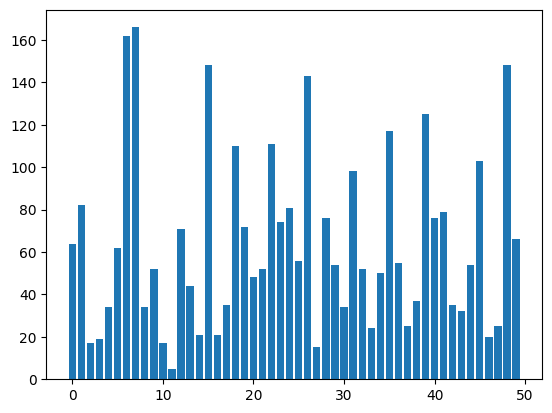

In [ ]:
plt.bar(range(50), nb_wrong_pred)
plt.show()

In [ ]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_wrong_pred[i]<=5:
        good_classification.append(i)
    if    nb_wrong_pred[i]>=60:
        bad_classification.append(i)

In [ ]:
def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(wrong_pred) if x == m]:
        wrong_pred_m.append(right_label[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

In [ ]:
for i in good_classification :
    print('ViT a bien classifie '+animals[i])

ViT a bien classifie mole


In [ ]:
for i in bad_classification:
    print('ViT a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

ViT a mal classifie antelope , melange souvent avec deer
ViT a mal classifie grizzly+bear , melange souvent avec lion
ViT a mal classifie persian+cat , melange souvent avec rabbit
ViT a mal classifie horse , melange souvent avec cow
ViT a mal classifie german+shepherd , melange souvent avec chihuahua
ViT a mal classifie tiger , melange souvent avec leopard
ViT a mal classifie moose , melange souvent avec buffalo
ViT a mal classifie elephant , melange souvent avec rhinoceros
ViT a mal classifie gorilla , melange souvent avec chimpanzee
ViT a mal classifie sheep , melange souvent avec horse
ViT a mal classifie seal , melange souvent avec otter
ViT a mal classifie chimpanzee , melange souvent avec gorilla
ViT a mal classifie squirrel , melange souvent avec rabbit
ViT a mal classifie rabbit , melange souvent avec deer
ViT a mal classifie wolf , melange souvent avec lion
ViT a mal classifie otter , melange souvent avec seal
ViT a mal classifie deer , melange souvent avec antelope
ViT a mal 